In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import tensorflow as tf
from tensorflow.keras import layers
import time

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/diabetes.arff')

In [4]:
diab_df = pd.DataFrame(diab_arf[0])

In [5]:
diab_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


In [6]:
diab_df['class'].value_counts()

b'tested_negative'    500
b'tested_positive'    268
Name: class, dtype: int64

In [7]:
diab_df.replace(to_replace=b'tested_negative', value=-1, inplace=True)
diab_df.replace(to_replace=b'tested_positive', value=1, inplace=True)

In [8]:
diab_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,-1
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,-1
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


In [16]:
# the values must be scaled to the range [-1,1] to match the output of the generator model
def scaler(df):
  for column in df:
    max = df[column].max()
    min = df[column].min()
    col = 2*((df[column] - min)/(max - min)) - 1
    df[column] = col
  return df

In [17]:
diab_df = scaler(diab_df)

In [18]:
diab_df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.547641,0.215020,0.132877,-0.585122,-0.811349,-0.046421,-0.663641,-0.591970,-0.302083
std,0.396421,0.321333,0.317308,0.322267,0.272444,0.234997,0.282945,0.392008,0.953903
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858454,-0.900000,-1.000000
50%,-0.647059,0.175879,0.180328,-0.535354,-0.927896,-0.046200,-0.748506,-0.733333,-1.000000
75%,-0.294118,0.409548,0.311475,-0.353535,-0.699173,0.090909,-0.531810,-0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
class GAN():
  def __init__(self):
    self.noise_dim = 100
    self.row_shape = (9,)
    self.num_examples_to_generate = 16

    self.generator = self.make_generator_model()
    self.discriminator = self.make_discriminator_model()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    z = tf.keras.layers.Input(shape=(self.noise_dim,))
    g_rows = self.generator(z)

    self.discriminator.trainable = False
    validity = self.discriminator(g_rows)

    # self.gan = 

    self.combined = tf.keras.Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

  def make_generator_model(self):
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, use_bias=False, input_dim=self.noise_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(32))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(9, activation='tanh'))

    model.summary()

    noise = tf.keras.layers.Input(shape=(self.noise_dim,))
    g_rows = model(noise)
    return tf.keras.Model(noise, g_rows)
    # return model

  def make_discriminator_model(self):
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, use_bias=False, input_shape=self.row_shape))
    # model.add(layers.Dense(32, use_bias=False, input_shape=(8,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(16))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    # opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    # model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    model.summary()

    g_rows = tf.keras.layers.Input(shape=self.row_shape)
    validity = model(g_rows)
    return tf.keras.Model(g_rows, validity)


  def train(self, df, epochs, batch_size=8):
    # (X_train, _), (_, _) = mnist.load_data()
    # X_train = X_train / 127.5 - 1.
    # X_train = np.expand_dims(X_train, axis=3)
    X_train = df.values
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    d_losses = np.zeros((epochs, 1))
    d_accuracies = np.zeros((epochs, 1))
    g_losses = np.zeros((epochs, 1))

    for i, epoch in enumerate(range(epochs)):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        rows = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))
        gen_rows = self.generator.predict(noise)
        d_loss_real = self.discriminator.train_on_batch(rows, valid)
        d_loss_fake = self.discriminator.train_on_batch(gen_rows, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))
        g_loss = self.combined.train_on_batch(noise, valid)

        d_losses[i] = d_loss[0]
        d_accuracies[i] = d_loss[1]
        g_losses[i] = g_loss
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        # if epoch % 10 == 0:
        #   noise = np.random.normal(0, 1, (1, self.noise_dim))
        #   gen_rows = self.generator.predict(noise)
        #   print(gen_rows)
    return (d_losses, d_accuracies, g_losses)

     


          # self.sample_images(epoch)
    # return model

  # def make_gan_model():
  #   model = Sequential()
  #   model.add(self.generator)
  #   model.add(self.discriminator)
  #   opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  #   model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
  #   return model


In [58]:
gan = GAN()
(d_losses, d_accuracies, g_losses) = gan.train(df=diab_df, epochs=500, batch_size=16)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 64)                6400      
_________________________________________________________________
batch_normalization_22 (Batc (None, 64)                256       
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 9)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


0 [D loss: 0.652349, acc.: 56.25%] [G loss: 0.871662]
1 [D loss: 0.719474, acc.: 37.50%] [G loss: 0.839230]
2 [D loss: 0.622223, acc.: 75.00%] [G loss: 0.907666]
3 [D loss: 0.651061, acc.: 50.00%] [G loss: 0.907486]
4 [D loss: 0.661944, acc.: 62.50%] [G loss: 0.889700]
5 [D loss: 0.612116, acc.: 68.75%] [G loss: 0.800969]
6 [D loss: 0.622278, acc.: 75.00%] [G loss: 0.892582]
7 [D loss: 0.688308, acc.: 65.62%] [G loss: 0.845607]
8 [D loss: 0.611908, acc.: 65.62%] [G loss: 0.848090]
9 [D loss: 0.667219, acc.: 53.12%] [G loss: 0.864979]
10 [D loss: 0.711950, acc.: 59.38%] [G loss: 0.786685]
11 [D loss: 0.665747, acc.: 65.62%] [G loss: 0.859589]
12 [D loss: 0.645594, acc.: 68.75%] [G loss: 0.869047]
13 [D loss: 0.649370, acc.: 75.00%] [G loss: 0.797266]
14 [D loss: 0.666418, acc.: 59.38%] [G loss: 0.828737]
15 [D loss: 0.631170, acc.: 71.88%] [G loss: 0.859481]
16 [D loss: 0.643631, acc.: 65.62%] [G loss: 0.832575]
17 [D loss: 0.618713, acc.: 68.75%] [G loss: 0.819306]
18 [D loss: 0.608203

In [53]:
import matplotlib.pyplot as plt
def show_plot(arr):
  x = range(arr.shape[0])
  plt.plot(x, arr)

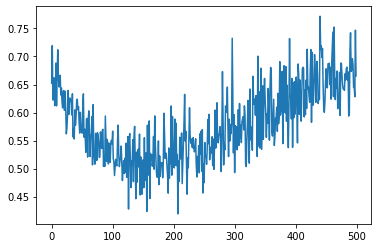

In [59]:
show_plot(d_losses)

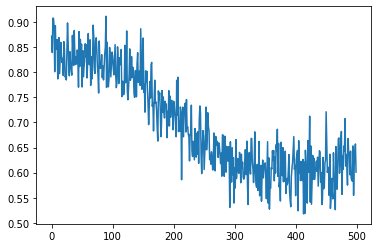

In [60]:
show_plot(g_losses)

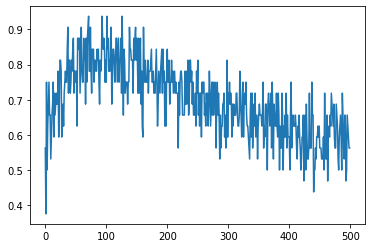

In [61]:
show_plot(d_accuracies)

In [ ]:
# tf.slice(generated_row, [0, 0], [1, 8])

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.49117926,  0.6104257 ,  0.12580083, -0.03930907, -0.5719336 ,
         0.12731908,  0.5741107 , -0.08067831]], dtype=float32)>